

---



# *Project Start*


*   Install and Import important Packages
*   Import the model
*   Transform the images
*   Generate Predicitons




# Install and Import Important Packages

In [1]:
%pip install lime
import os
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import cv2
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split


from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
%matplotlib inline
print('Notebook run using keras:', keras.__version__)
#display
from IPython.display import Image, display


Note: you may need to restart the kernel to use updated packages.
Notebook run using keras: 3.5.0


In [9]:

# Assuming your folder is in 'My Drive/my_folder'
folder_path = './data/pancreas/pancreas/pancreas/'  # Replace with your actual folder path

# List all files in the folder
!ls "{folder_path}"

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
folder_path = "C:/Users/saadr/Desktop/Nuova cartella/M2/S3/XAI Project/src/data/pancreas/pancreas/"
path = "C:/Users/saadr/Desktop/Nuova cartella/M2/S3/XAI Project/src/data/pancreas/pancreas/image/"

In [16]:
path= folder_path + "image/"
print(path)


C:/Users/saadr/Desktop/Nuova cartella/M2/S3/XAI Project/src/data/pancreas/pancreas/image/




---



In [17]:
import os

if not os.path.exists(path):
    raise FileNotFoundError(f"The directory {path} does not exist.")

In [18]:
batch_size = 16
img_height = 299
img_width = 299

Found 361 files belonging to 2 classes.
Number of training batches:   16
Number of validation batches: 4
Number of testing batches:    3
Total training samples:       256
Total validation samples:     64
Total testing samples:        48


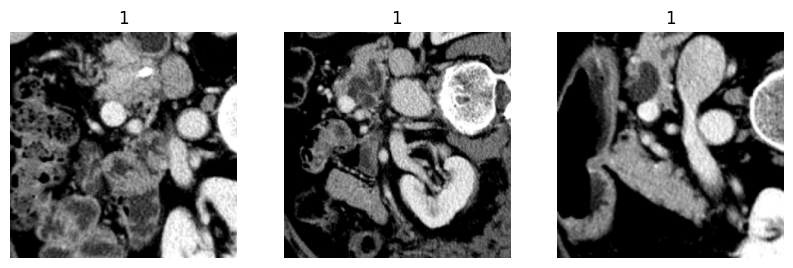

In [19]:
def loading_data(path, batch_size, img_height, img_width, train_ratio, val_ratio):
  # Load the full dataset from both pos and neg folders
  full_ds = tf.keras.preprocessing.image_dataset_from_directory(
      path,
      labels='inferred',
      label_mode='int',
      batch_size=batch_size,
      image_size=(img_height, img_width),
      shuffle=True,
      seed=1
  )

  # Get total number of batches
  num_batches = full_ds.cardinality().numpy()
  train_size = int(train_ratio * num_batches)  # 70% training
  val_size = int(val_ratio * num_batches)    # 20% validation
  test_size = num_batches - train_size - val_size  # 10% testing

  # Split the dataset
  train_ds = full_ds.take(train_size)
  val_ds = full_ds.skip(train_size).take(val_size)
  test_ds = full_ds.skip(train_size + val_size).take(test_size)

  print(f"Number of training batches:   {train_ds.cardinality()}")
  print(f"Number of validation batches: {val_ds.cardinality()}")
  print(f"Number of testing batches:    {test_ds.cardinality()}")

  print(f"Total training samples:       {train_ds.cardinality().numpy() * batch_size}")
  print(f"Total validation samples:     {val_ds.cardinality().numpy() * batch_size}")
  print(f"Total testing samples:        {test_ds.cardinality().numpy() * batch_size}")

   # Plot some images from the training dataset
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):  # Take one batch of images
      for i in range(3):  # Plot the first 9 images
          ax = plt.subplot(3, 3, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))  # Extract individual image
          plt.title(int(labels[i])) # Convert label to class name
          plt.axis("off")
  plt.show()

  return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = loading_data(path, batch_size, img_height, img_width, train_ratio= 0.7, val_ratio=0.2)

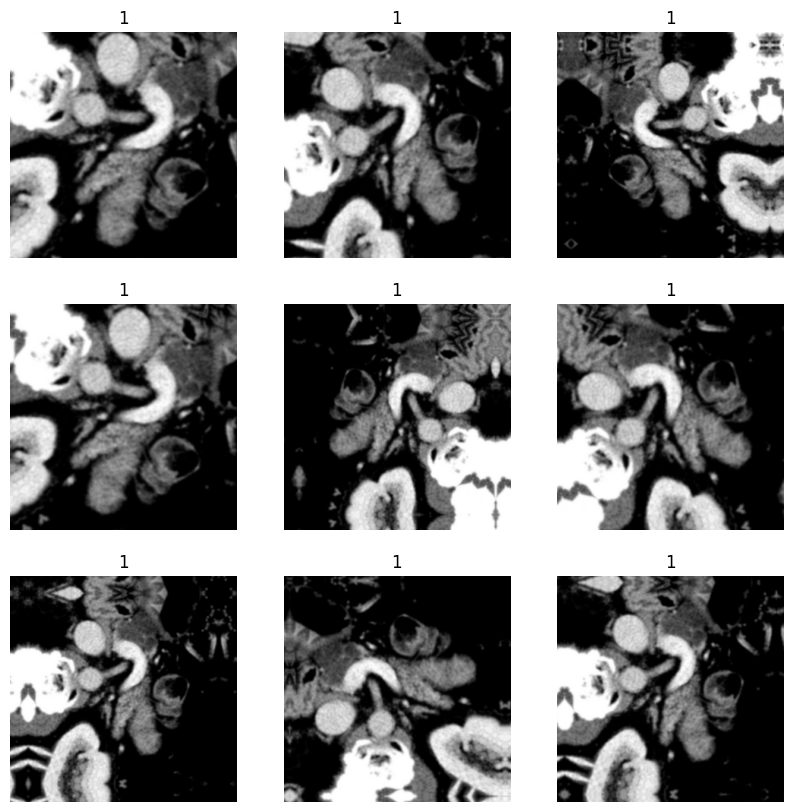

In [20]:
def preprocess_data(train_ds, val_ds, test_ds, resize_dim):

  resize_fn = keras.layers.Resizing(resize_dim, resize_dim)

  train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
  val_ds = val_ds.map(lambda x, y: (resize_fn(x), y))
  test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))


  augmentation_layers = [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.2),
  ]


  def data_augmentation(x):
      for layer in augmentation_layers:
          x = layer(x)
      return x


  train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

  for images, labels in train_ds.take(1):
      plt.figure(figsize=(10, 10))
      first_image = images[0]
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          augmented_image = data_augmentation(np.expand_dims(first_image, 0))
          plt.imshow(np.array(augmented_image[0]).astype("int32"))
          plt.title(int(labels[0]))
          plt.axis("off")

  return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds= preprocess_data(train_ds, val_ds, test_ds, resize_dim= img_width)

# Install the base model and fine tune it

In [21]:
batch_size

16

In [22]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

print("Test dataset evaluation")
model.evaluate(test_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 299, 299, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 299, 299, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 10, 10, 2048)  │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Fitting the top layer of the model
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - binary_accuracy: 0.5646 - loss: 0.5688 - val_binary_accuracy: 0.7500 - val_loss: 0.5446
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - binary_accuracy: 0.7929 - loss: 0.4878 - val_binary_accuracy: 0.8750 - val_loss: 0.4293
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - binary_accuracy: 0.8887 - loss: 0.3796 - val_binary_accuracy: 0.9219 - val_loss: 0.3150
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - binary_accuracy: 0.9184 - loss: 0.2954 - val_binary_accuracy: 0.8750 - val_loss: 0.3548
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - binary_accuracy: 0.9147 - loss: 0.2877 - val_binary_accuracy: 0.9219 - val_loss: 0.2763
Test dataset evaluation
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - binary_accuracy: 0.8487 - loss: 0.3357


[0.32695984840393066, 0.8536585569381714]

In [23]:
model.save(path +'./model_xception_batch16_epoch5_imgsize299.keras')
inet_model = model



---

